# Train classifiers and evaluate

The data set I have has labelled observations; each data point, "spot", has been annotated as either cancer or non-cancer by a pathologist. I will use the expression data to fit a model to these labels, and see whether accurate predictions can be made on new data.

The labels have been binarized as either 'cancer' or 'healthy' to simplify the process, thus I will try different binary classifiers to perform the supervised learning.  

Resources:  
* https://en.wikipedia.org/wiki/Binary_classification
* https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

<br>
Classifiers of interest to try out:  

* Logistic regression --- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
* Random forest --- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* SVM --- https://scikit-learn.org/stable/modules/svm.html
* Nearest neighbors --- https://scikit-learn.org/stable/modules/neighbors.html
* Gaussian Naive Bayes --- https://scikit-learn.org/stable/modules/naive_bayes.html

<br>

When training and evaluating the model I will use cross validation (CV), with the approach to leave-one-out based on sample ID, in order to mimic how the model should be used for new test data. The method in scikit-learn that fits this purpose is the LeaveOneGroupOut approach: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html

## Set up

In [7]:
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import os.path as osp
import argparse as arp
import sys
import warnings
warnings.filterwarnings("ignore")

In [8]:
import sklearn

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

In [2]:
DIR = '/'.join(osp.realpath(getsourcefile(lambda: 0)).split('/')[:-2])
DIR_DATA = DIR + '/data/her2st'
print('', DIR, '\n', DIR_DATA)

 /Users/lovisa.franzen/Documents/Courses/ml_medbioinfo_2020/ml_project 
 /Users/lovisa.franzen/Documents/Courses/ml_medbioinfo_2020/ml_project/data/her2st


***

## Train data

### Read data

In [3]:
train_df = pd.read_csv(os.path.join(DIR_DATA, 'train_df.tsv'), sep='\t')
train_df

,A2M,A4GALT,AAAS,AACS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZYX,ZZEF1,ZZZ3,label_cancer,sample_id,spot_id,x,y,exp_sum,exp_mean
0,0.2403,0.0000,0.0000,0.0,0.0000,0.0,0.3024,0.0,0.0000,0.0000,...,0.3200,0.0,0.0000,healthy,C1,10x16,10,16,868.647198,0.136903
1,0.5000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000,...,0.3329,0.0,0.0000,healthy,C1,10x17,10,17,563.050300,0.088739
2,0.0000,0.0000,1.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000,...,0.1724,0.0,0.8115,healthy,C1,10x18,10,18,781.124198,0.123109
3,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000,...,0.7742,0.0,0.0000,healthy,C1,10x19,10,19,669.868001,0.105574
4,0.2020,0.3115,0.0000,0.0,0.5501,0.0,0.0847,0.0,0.4099,0.2544,...,0.3138,0.0,0.4220,cancer,C1,10x20,10,20,998.524699,0.157372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2527,0.5060,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000,...,0.1828,0.0,0.0000,cancer,H1,9x29,9,29,295.169100,0.046520
2528,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.1494,0.0000,...,0.0000,0.0,0.0000,cancer,H1,9x30,9,30,284.137799,0.044781
2529,0.5036,0.0000,0.1766,0.0,0.0000,0.0,0.0000,0.0,0.3006,0.1460,...,0.0963,0.0,0.0000,cancer,H1,9x31,9,31,280.177000,0.044157
2530,0.2133,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000,...,0.1156,0.0,0.0000,cancer,H1,9x32,9,32,221.716100,0.034943


In [6]:
train_samples = train_df['sample_id'].unique().tolist()
train_samples

['C1', 'E1', 'F1', 'G2', 'H1']

***

### Process data features

For the model to work, the features needs to be in the correct format (binarized and/or numerical). Only the expression data will be used to train the model, so all other columns need to be dropped. The "sample_id" feature will be used to perform the CV, while the "label_cancer" is our labels to fit the model to. The spot related features are only needed for plotting the data spatially and has not other purpose in this project.

**Encode 'sample_id' features**

In [14]:
le = preprocessing.LabelEncoder()
le.fit(train_df['sample_id'])
list(le.classes_)

['C1', 'E1', 'F1', 'G2', 'H1']

In [15]:
train_df['sample_id_num'] = le.transform(train_df['sample_id'])

In [19]:
#list(le.inverse_transform(le.transform(train_df['sample_id'])))

**Encode label (y)**  
First the cancer label is binarized to 0, 1 and then I adjust the label so that healthy (baseline) is 0 and cancer is 1.

In [20]:
le = preprocessing.LabelEncoder()
le.fit(train_df['label_cancer'])
list(le.classes_)

['cancer', 'healthy']

In [38]:
train_df['label_bin'] = le.transform(train_df['label_cancer'])

In [40]:
train_df['label'] = np.abs(train_df['label_bin']-1)

In [47]:
#sns.countplot(x="label", hue='sample_id_num', data=train_df).set_title("Tain data")
#plt.show();
#sns.countplot(x="label_cancer", hue='sample_id', data=train_df).set_title("Tain data")
#plt.show();

**Identify X features**

For training, only gene expression features will be used. Since we have expression data for more than 12000 genes, I will select only the most variable genes to train the model on in order to reduce the number of features and simply the model.

This final training data will be allocated to *X*.

In [59]:
len(train_df.columns)

12699

In [58]:
columns_remove = train_df.columns[-10:]
print(columns_remove)
columns_keep = train_df.columns.copy()
columns_keep = [s for s in columns_keep if s not in columns_remove]
len(columns_keep)

Index(['label_cancer', 'sample_id', 'spot_id', 'x', 'y', 'exp_sum', 'exp_mean',
       'sample_id_num', 'label', 'label_bin'],
      dtype='object')


12689

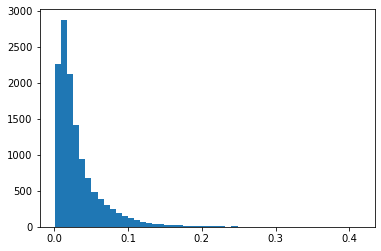

In [68]:
plt.hist(np.mean(train_df.loc[:,columns_keep]), bins=50);

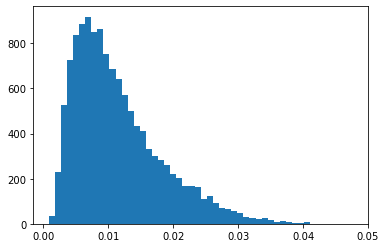

In [69]:
plt.hist(np.var(train_df.loc[:,columns_keep]), bins=50);

In [84]:
var_001 = np.var(train_df.loc[:,columns_keep])>0.01
var_002 = np.var(train_df.loc[:,columns_keep])>0.02

In [85]:
var_001_true = np.sum(var_001)
var_001_false = len(var_001) - var_001_true
var_002_true = np.sum(var_002)
var_002_false = len(var_002) - var_002_true

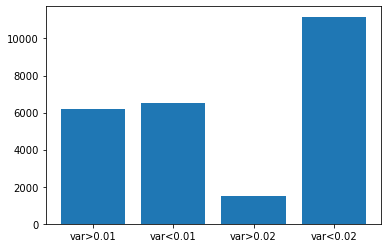

In [86]:
plt.bar(['var>0.01', 'var<0.01', 'var>0.02', 'var<0.02'],
        [var_001_true, var_001_false, var_002_true, var_002_false],
        align='center')

*To start off, I will select only the genes showing a variance greater than 0.02, as that limits the number of genes significantly.*

**Create train set X**  
Create a new train set with a reduced number of features, keeping only genes showing a variance across observations greater than 0.02.

In [126]:
train_df_reduced = train_df.copy()
train_df_reduced = train_df_reduced.loc[:, columns_keep]

In [138]:
feat_train = np.array(columns_keep)[var_002.tolist()].tolist()
print(len(feat_train))
feat_train[:8]

1517


['A2M', 'ABCA3', 'ABHD11', 'ABHD14B', 'ABL1', 'ABLIM1', 'ACADVL', 'ACAP3']

In [128]:
train_df_reduced = train_df_reduced.iloc[:,var_002.tolist()]
train_df_reduced.shape

(2532, 1517)

In [129]:
X = np.array(train_df_reduced)

***

## Fit models

**Define classifiers**

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=100,
                                max_depth=None,
                                min_samples_split=2,
                                n_jobs=4,
                                random_state=None,
                                verbose=0)

In [ ]:
clf_svm = svm.SVC(gamma=0.001, C=100.)

## Model evaluation and comparison

## Model selection